In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm import tqdm
from pprint import pprint

import seaborn as sns
sns.set_style("darkgrid")

Reading data:

In [2]:
files = sorted(glob.glob('data/*.json'))

data = []

for i, file in enumerate(files):
    with open(file, 'r') as f:
        json_file = json.load(f)
        print('Sample{index} contains {n} queries'.format(index=i+1,n=len(json_file)))
        data.append(json_file)

Sample1 contains 9275 queries
Sample2 contains 40468 queries
Sample3 contains 7537 queries
Sample4 contains 16887 queries
Sample5 contains 36601 queries
Sample6 contains 762 queries
Sample7 contains 11360 queries
Sample8 contains 9 queries


Sample8 has only 9 queries, so we drop it.

In [3]:
del data[-1]
assert len(data)==7

In [4]:
# json -> pd.Dataframe
for i, sample in enumerate(data):
    df = pd.DataFrame(columns=['time_stamp','query'])
    df['time_stamp'] = [e['time'] for e in sample]
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df['year'] = df['time_stamp'].apply(lambda x: x.year)
    df['query'] = [e['title'][13:] for e in sample]
    
    print('Sample{}:'.format(i+1))
    print(df.head(3),'\n')
    
    data[i] = df

Sample1:
                        time_stamp                           query  year
0 2020-10-28 12:30:18.060000+00:00   does python read line by line  2020
1 2020-10-28 12:08:44.380000+00:00           real time vs cpu time  2020
2 2020-10-28 12:05:30.968000+00:00  does python read top to bottom  2020 

Sample2:
                        time_stamp                       query  year
0 2020-11-06 14:46:25.559000+00:00         bash append to file  2020
1 2020-11-06 14:42:38.618000+00:00               bash for loop  2020
2 2020-11-06 14:33:23.067000+00:00  jupyter notebook bash cell  2020 

Sample3:
                        time_stamp                                 query  year
0 2019-06-29 11:43:55.066000+00:00                      бутыль воды 19 л  2019
1 2019-06-29 07:02:30.796000+00:00                           pdf to word  2019
2 2019-06-29 06:59:22.277000+00:00  акт приема передачи жилого помещения  2019 

Sample4:
                        time_stamp  \
0 2020-11-21 05:38:44.558000+00:00  

In [5]:
def is_english(s):
    """ 
    Checks if the input string contains non-English alphabet characters. 
    
    Parameters
    ----------
    s : str
        Input string.
        
    Returns
    ----------
    True if the input string contains only English alphabet characters, otherwise false.
    """    
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [6]:
for i, sample in enumerate(data):
    count = 0
    for q in sample['query']:
        if is_english(q):
            count+=1
    
    share = np.round(100 * count/len(sample['query']),2)
    print('Share of English queries in Sample{index} = {p}%'.format(index=i+1,p=share))

Share of English queries in Sample1 = 99.3%
Share of English queries in Sample2 = 97.33%
Share of English queries in Sample3 = 58.56%
Share of English queries in Sample4 = 93.37%
Share of English queries in Sample5 = 96.56%
Share of English queries in Sample6 = 99.61%
Share of English queries in Sample7 = 58.04%


Vizualizing the number of searches per year for each of the samples:

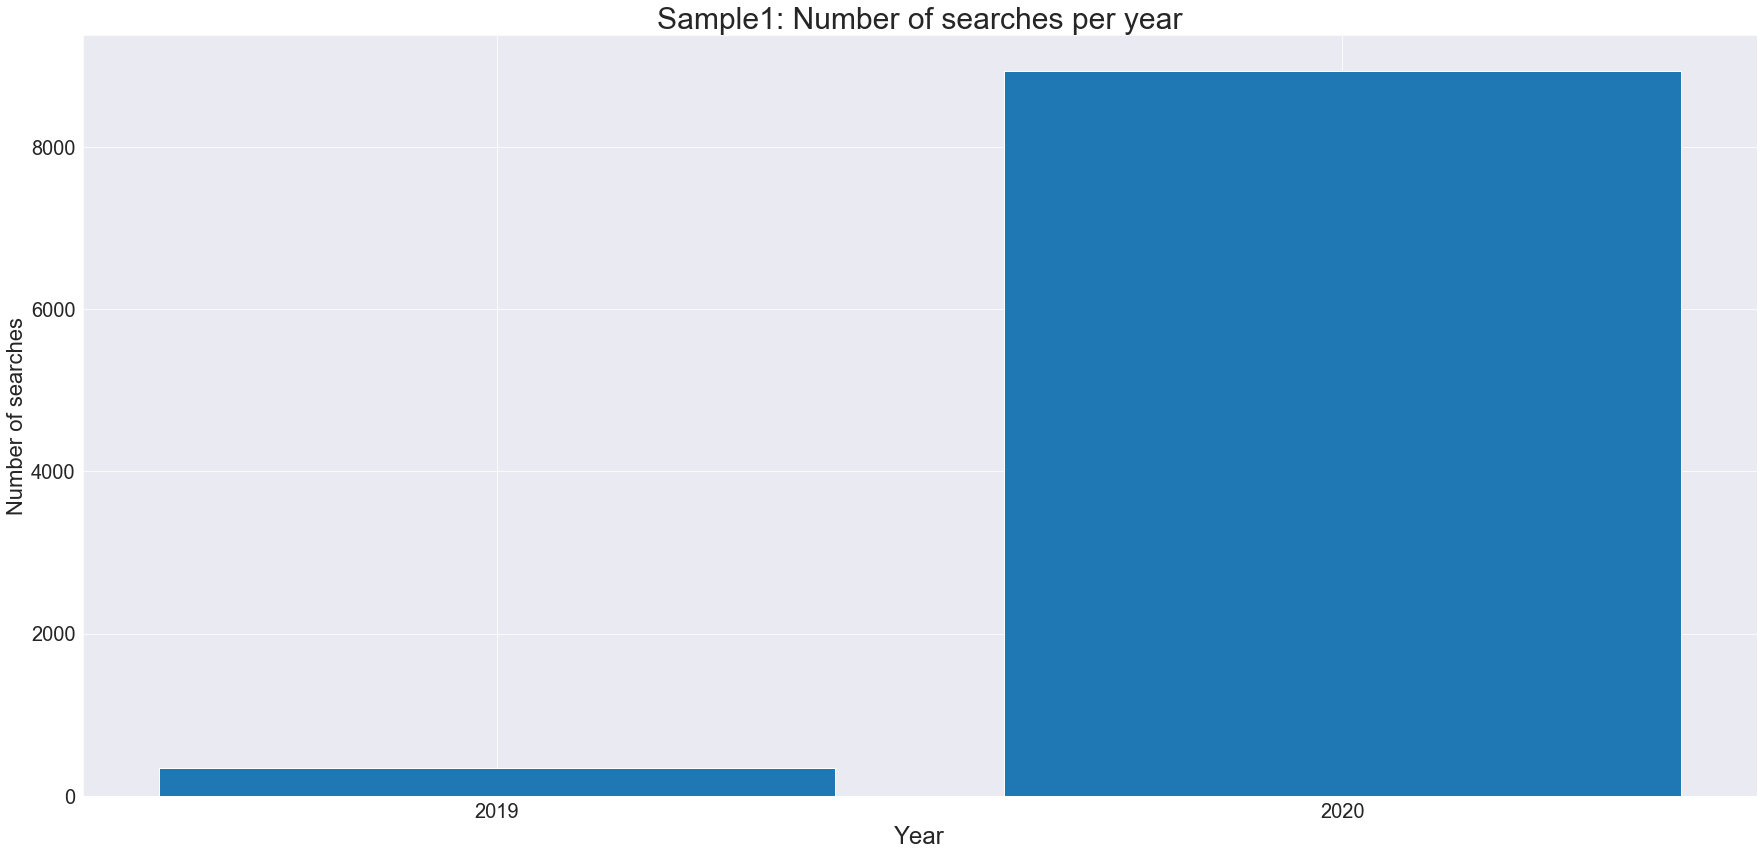

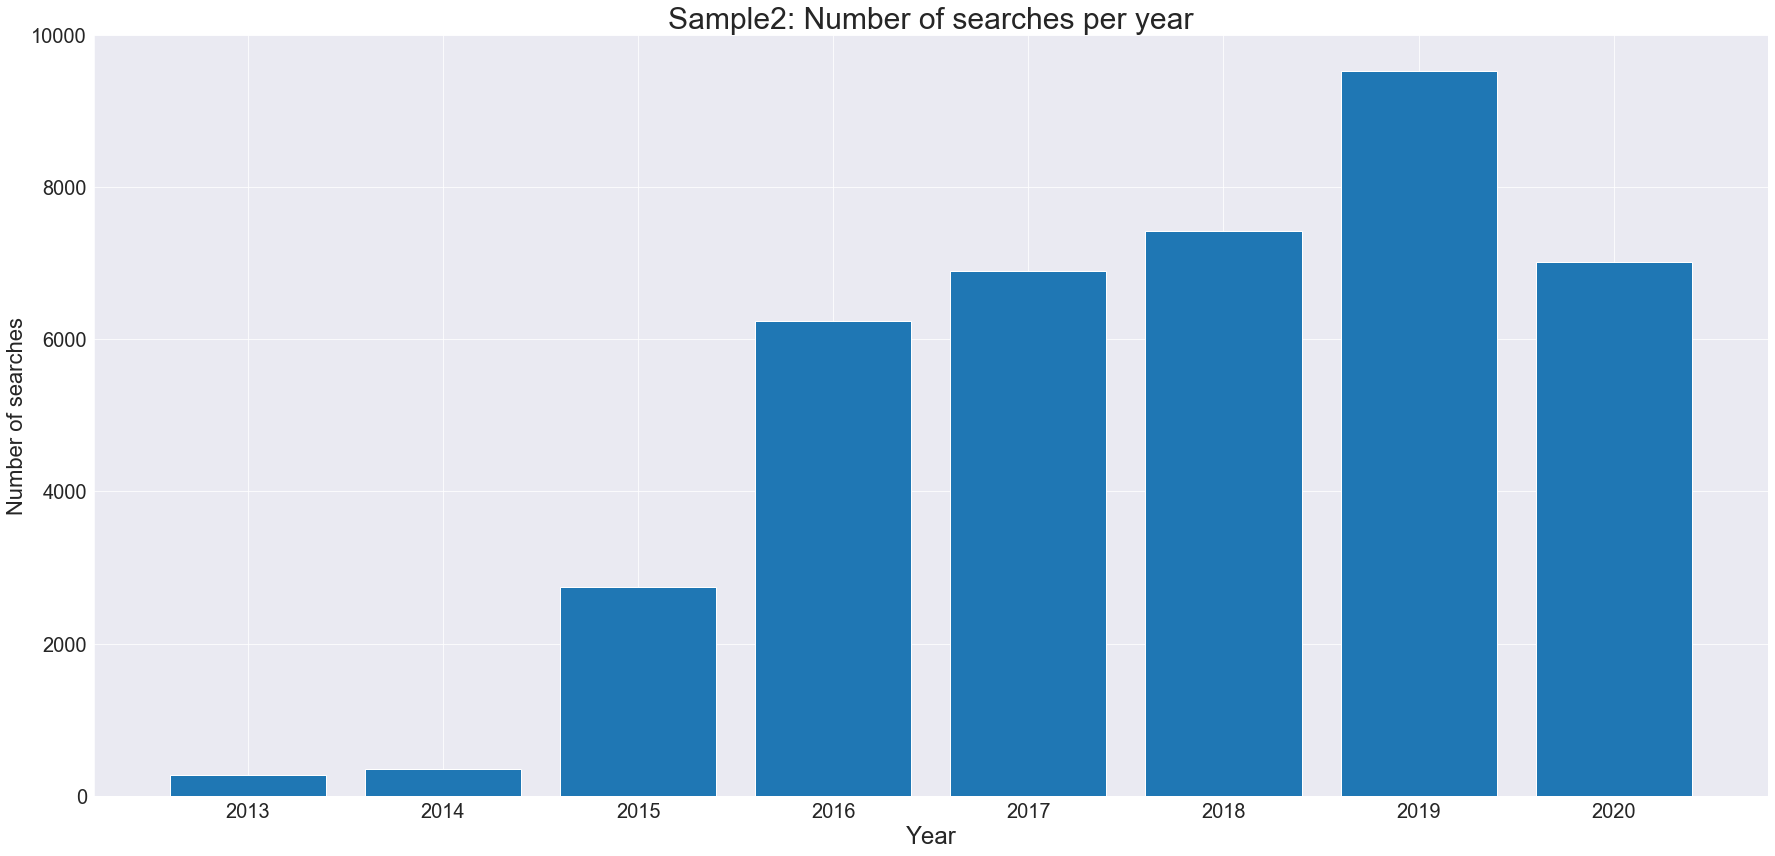

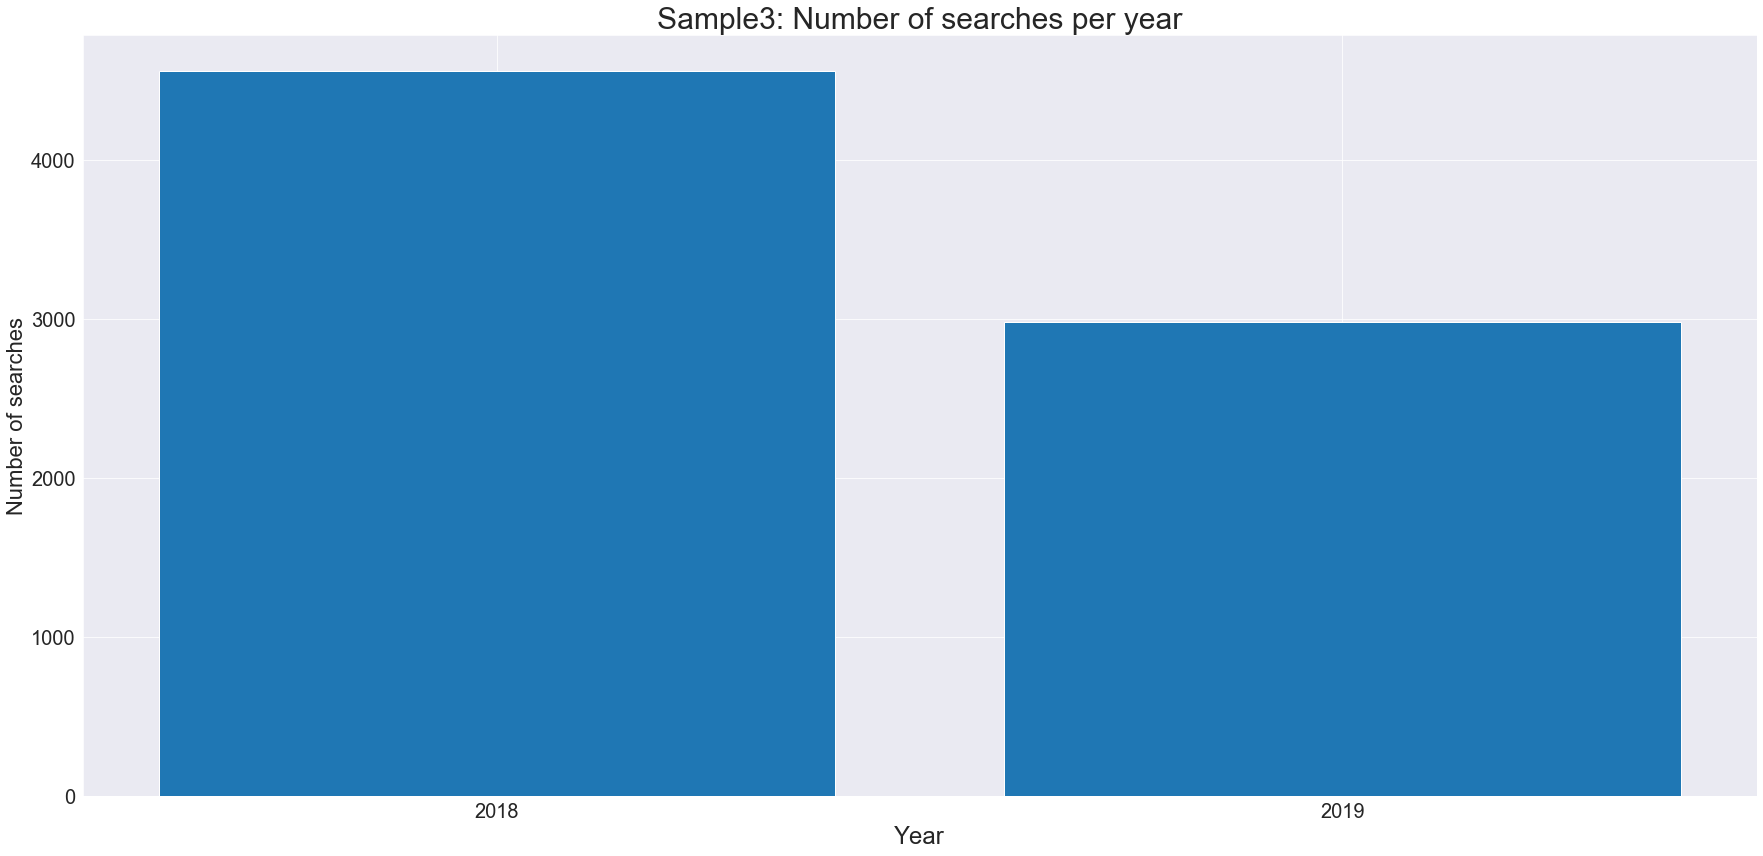

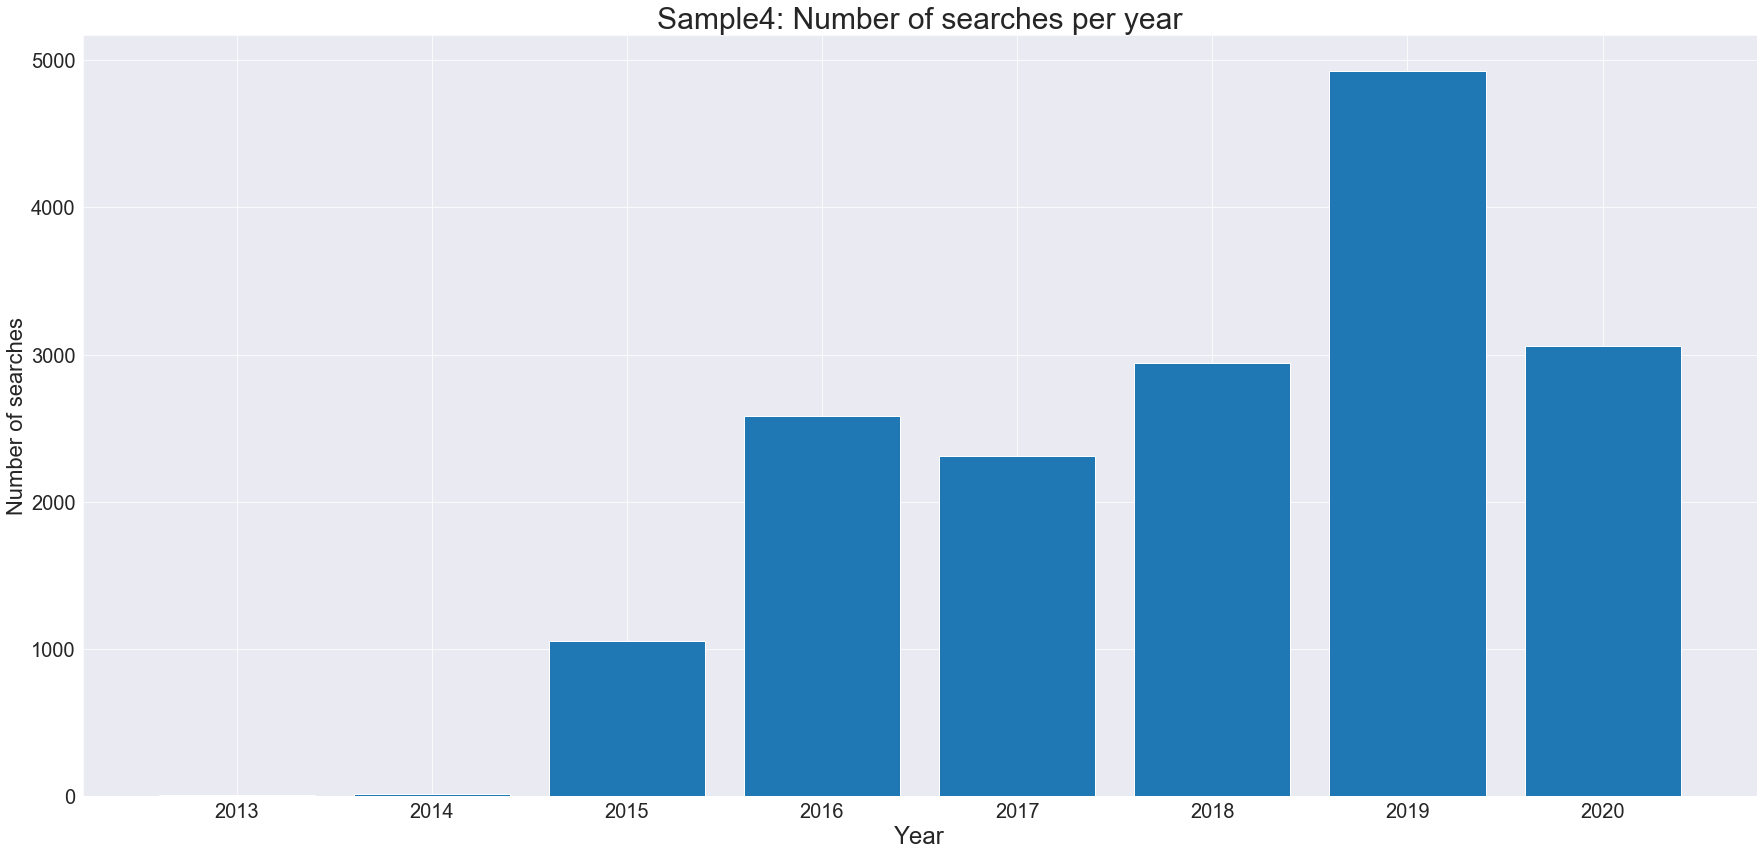

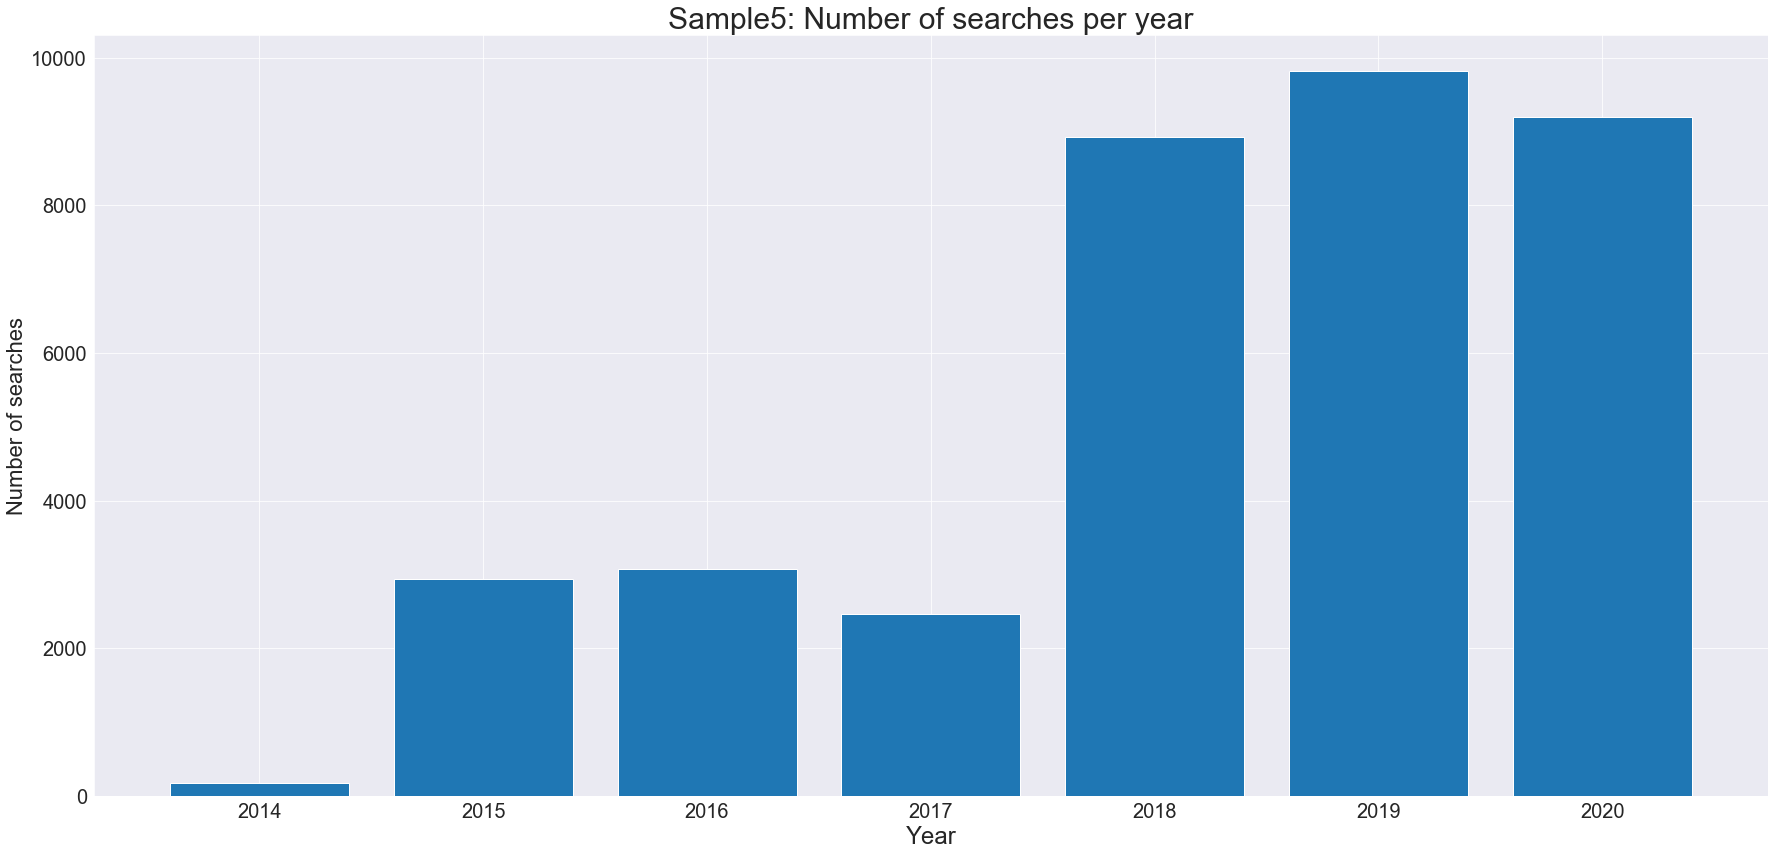

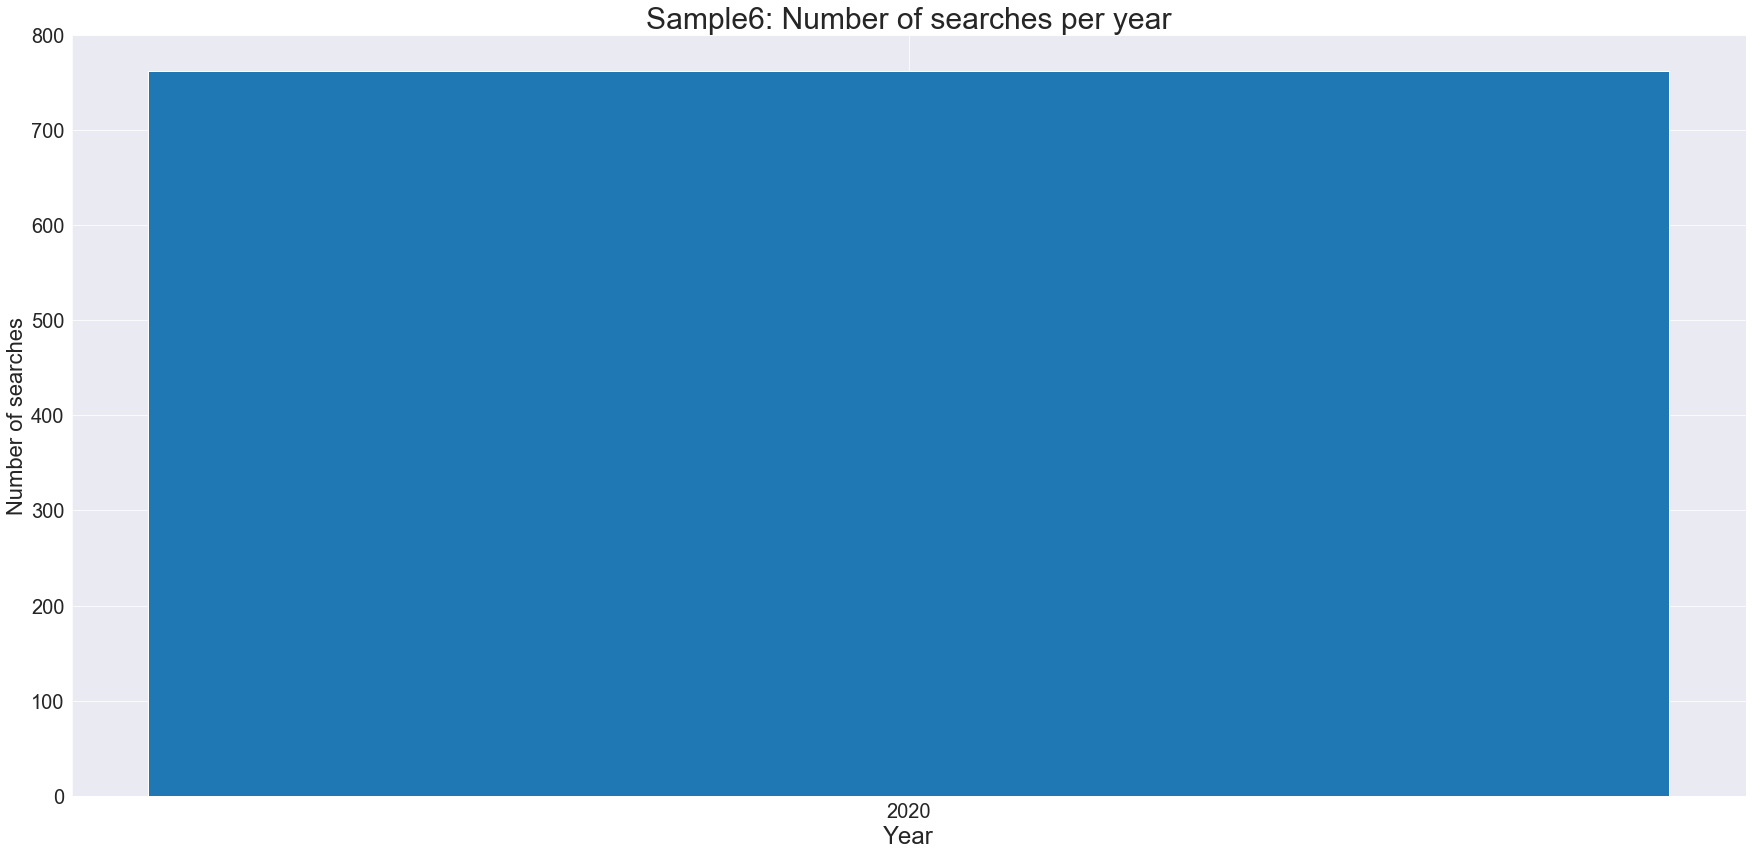

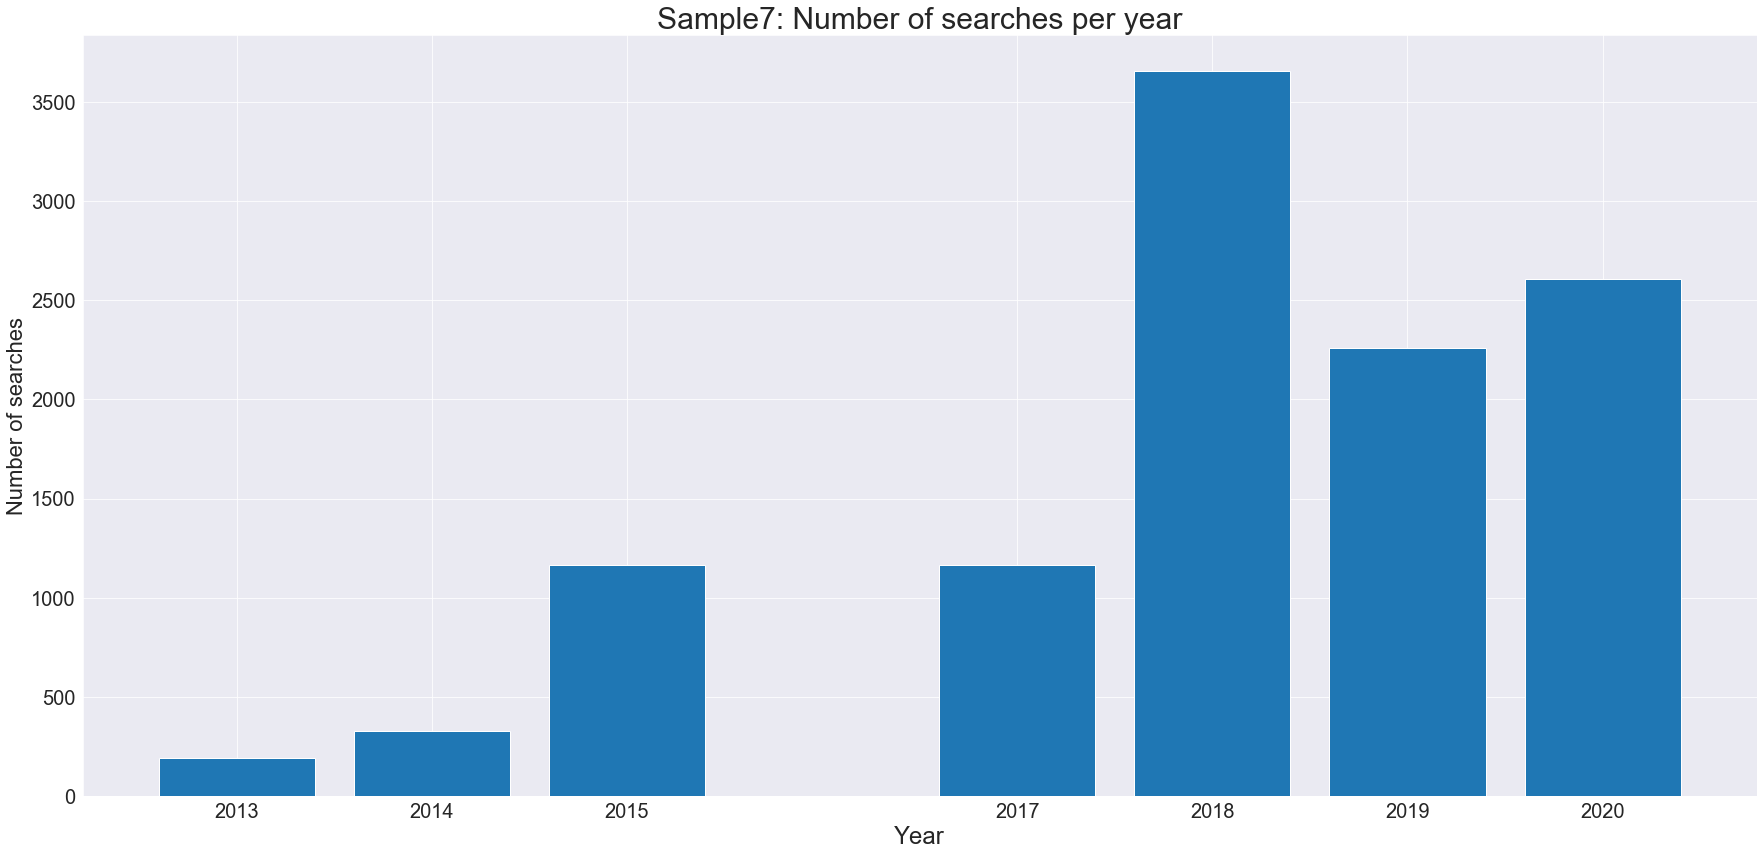

In [7]:
for i, sample in enumerate(data):
    distr = sample['year'].value_counts().sort_index()
    plt.figure(figsize=(30,14))
    plt.bar(distr.index,distr.values)
    plt.title('Sample{}: Number of searches per year'.format(i+1),fontsize=30)
    plt.xlabel('Year',fontsize=24)
    plt.ylabel('Number of searches',fontsize=22)
    plt.xticks(distr.index,distr.index,fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

----------------------------------------------------------------------------------------------------------------

### Data processing

Let's now do some data processing to understand the data better and obtain more interesting and informative vizualizations.

Importing the necessary libraries first:

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['use','used',
                   'take','took','taken',
                   'begin','began','begun',
                   'build','built',
                   'do','did','done',
                   'find','found',
                   'get','got','gotten',
                   'give','gave','given',
                   'make','made'])

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def tokenize(docs,deacc=False):
    """ 
    Generator function for tokenizing a string.
    
    Parameters
    ----------
    docs : list
        List of strings to be tokenized.
    
    deacc : bool, optional
        If true, removes accent marks from tokens.
        
    Returns
    ----------
    An iterator of tokenized strings (one value at a time)
    """
    for d in docs:
        yield(gensim.utils.simple_preprocess(d, deacc=deacc))
        

def remove_stopwords(docs_tok):
    """ 
    Removing stop words from a tokenized string.
    
    Parameters
    ----------
    docs_tok : list
        List of tokenized strings.
        
    Returns
    ----------
    List of tokenized strings without stop words. 
    """
    return [[word for word in doc if word not in stop_words] for doc in docs_tok]


def lemmatization(docs_tok, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """ 
    Lemmatizing tokens.
    
    Parameters
    ----------
    docs_tok : list
        List of tokenized strings.
    
    allowed_postags: list, optional
        Part-of-speech tags to be kept in tokenized strings. Default keeps nouns, adjectives, verbs, adverbs,
        and proper nouns.
        
    Returns
    ----------
    List of tokenized strings with lemmatized tokens.  
    """
    result = []
    for d in tqdm(docs_tok):
        doc = nlp(" ".join(d)) 
        result.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return result

In [10]:
processed_data = []

for i, sample in enumerate(data):
    queries = sample['query'].values.tolist()
    queries_tok = tokenize(queries)
    queries_cln = remove_stopwords(queries_tok)
#     queries_cln = lemmatization(queries_cln)
    
    print('Sample{}'.format(i+1))
    print('-----------------')
    pprint(queries_cln[:5])
    print('\n')
    
    processed_data.append(queries_cln)

Sample1
-----------------
[['python', 'read', 'line', 'line'],
 ['real', 'time', 'vs', 'cpu', 'time'],
 ['python', 'read', 'top', 'bottom'],
 ['sas', 'excel'],
 ['sas', 'dollar', 'sign', 'format']]


Sample2
-----------------
[['bash', 'append', 'file'],
 ['bash', 'loop'],
 ['jupyter', 'notebook', 'bash', 'cell'],
 ['nc', 'multiple', 'inputs', 'command', 'line'],
 ['python', 'netcat']]


Sample3
-----------------
[['бутыль', 'воды'],
 ['pdf', 'word'],
 ['акт', 'приема', 'передачи', 'жилого', 'помещения'],
 ['договор', 'найма', 'жилого', 'помещения'],
 ['акт',
  'возврата',
  'жилого',
  'помещения',
  'при',
  'расторжении',
  'договора',
  'найма',
  'pdf']]


Sample4
-----------------
[['salty', 'water', 'dehydrates'],
 ['gith'],
 ['error',
  'invalid',
  'value',
  'parameter',
  'overrides',
  'access_token',
  'eaaaegrdyevo',
  'vslvwi',
  'rts',
  'juhotywwwt',
  'cjh',
  'eiw',
  'dhwow',
  'xt',
  'mi',
  'dkra',
  'valid',
  'format'],
 ['access_token',
  'eaaaegrdyevo',
  'vs

In [11]:
from collections import Counter, OrderedDict

for i, sample in enumerate(processed_data):
    
    print('Sample{}'.format(i+1))
    print('-----------------')
    
    words = [word for doc in sample for word in doc]
    
    print('Total number of words in all queries taken together = {}'.format(len(words)))
    print('Total number of unique words = {}\n'.format(len(set(words))))

Sample1
-----------------
Total number of words in all queries taken together = 27100
Total number of unique words = 4436

Sample2
-----------------
Total number of words in all queries taken together = 122214
Total number of unique words = 15578

Sample3
-----------------
Total number of words in all queries taken together = 20326
Total number of unique words = 6615

Sample4
-----------------
Total number of words in all queries taken together = 53875
Total number of unique words = 12235

Sample5
-----------------
Total number of words in all queries taken together = 101852
Total number of unique words = 14816

Sample6
-----------------
Total number of words in all queries taken together = 1553
Total number of unique words = 716

Sample7
-----------------
Total number of words in all queries taken together = 26002
Total number of unique words = 9870



Let's visualize the distribution of word frequences for each of our samples.

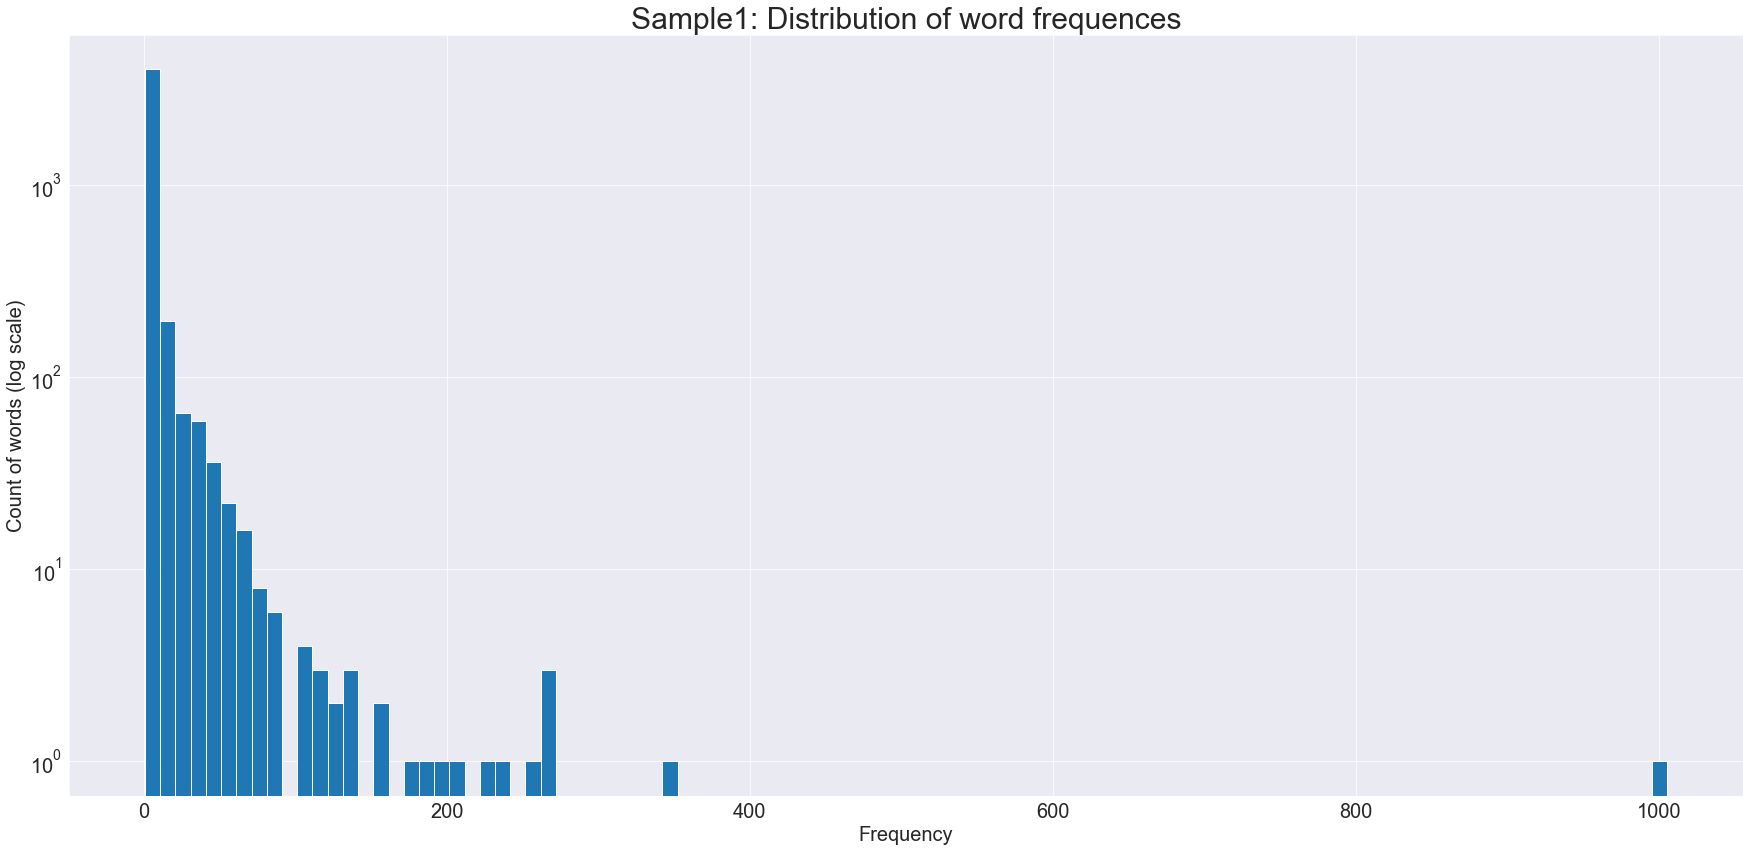

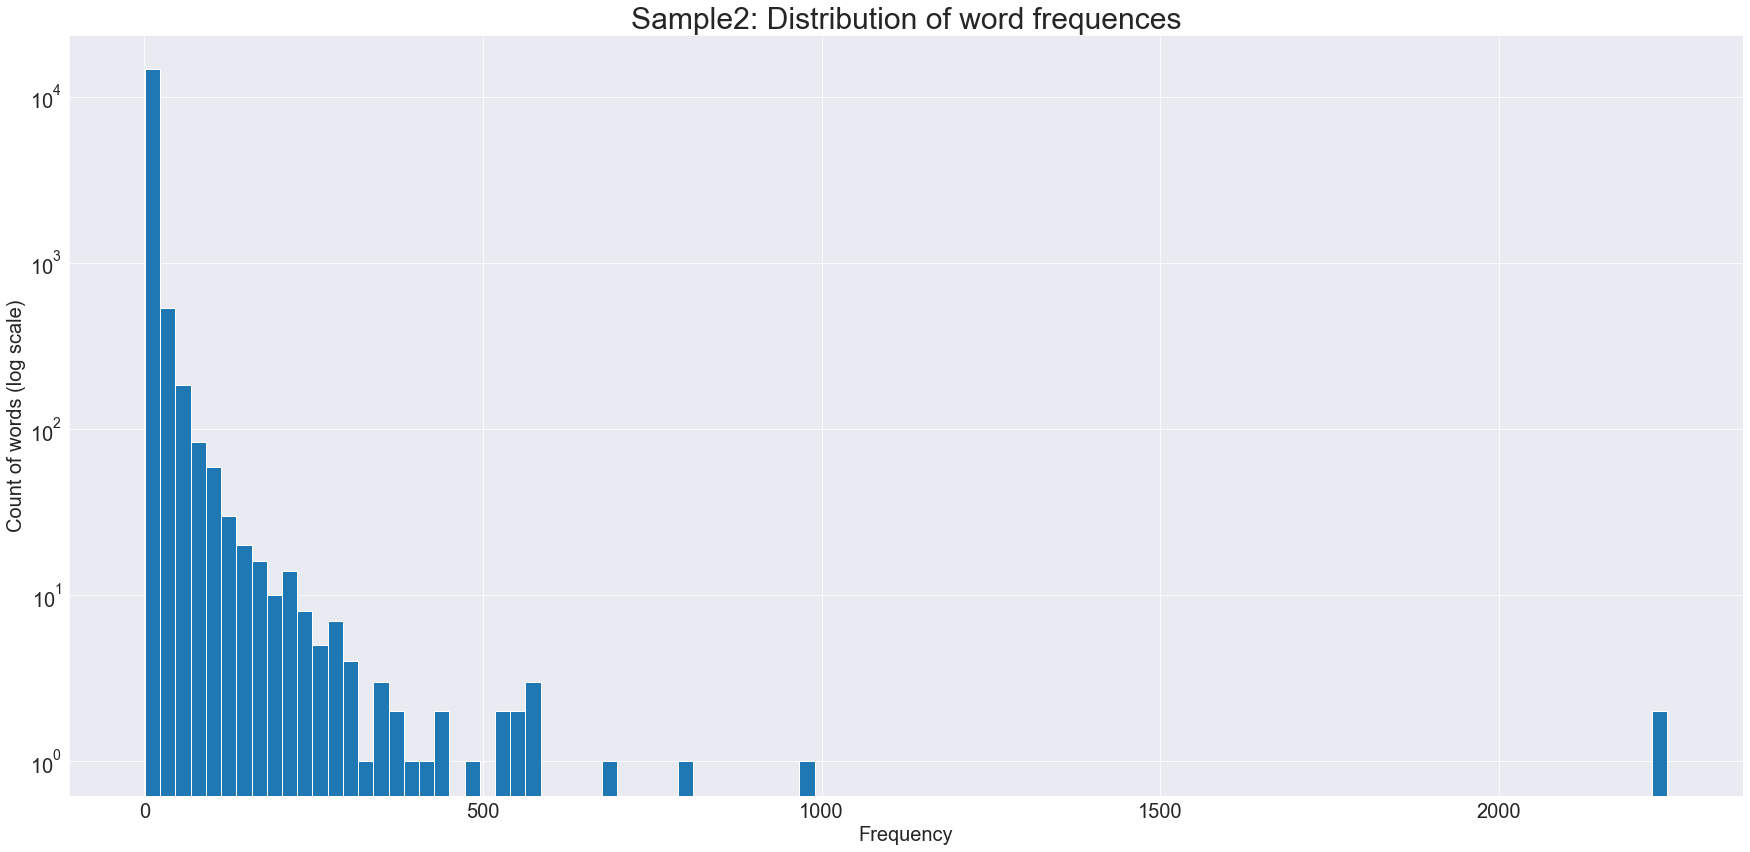

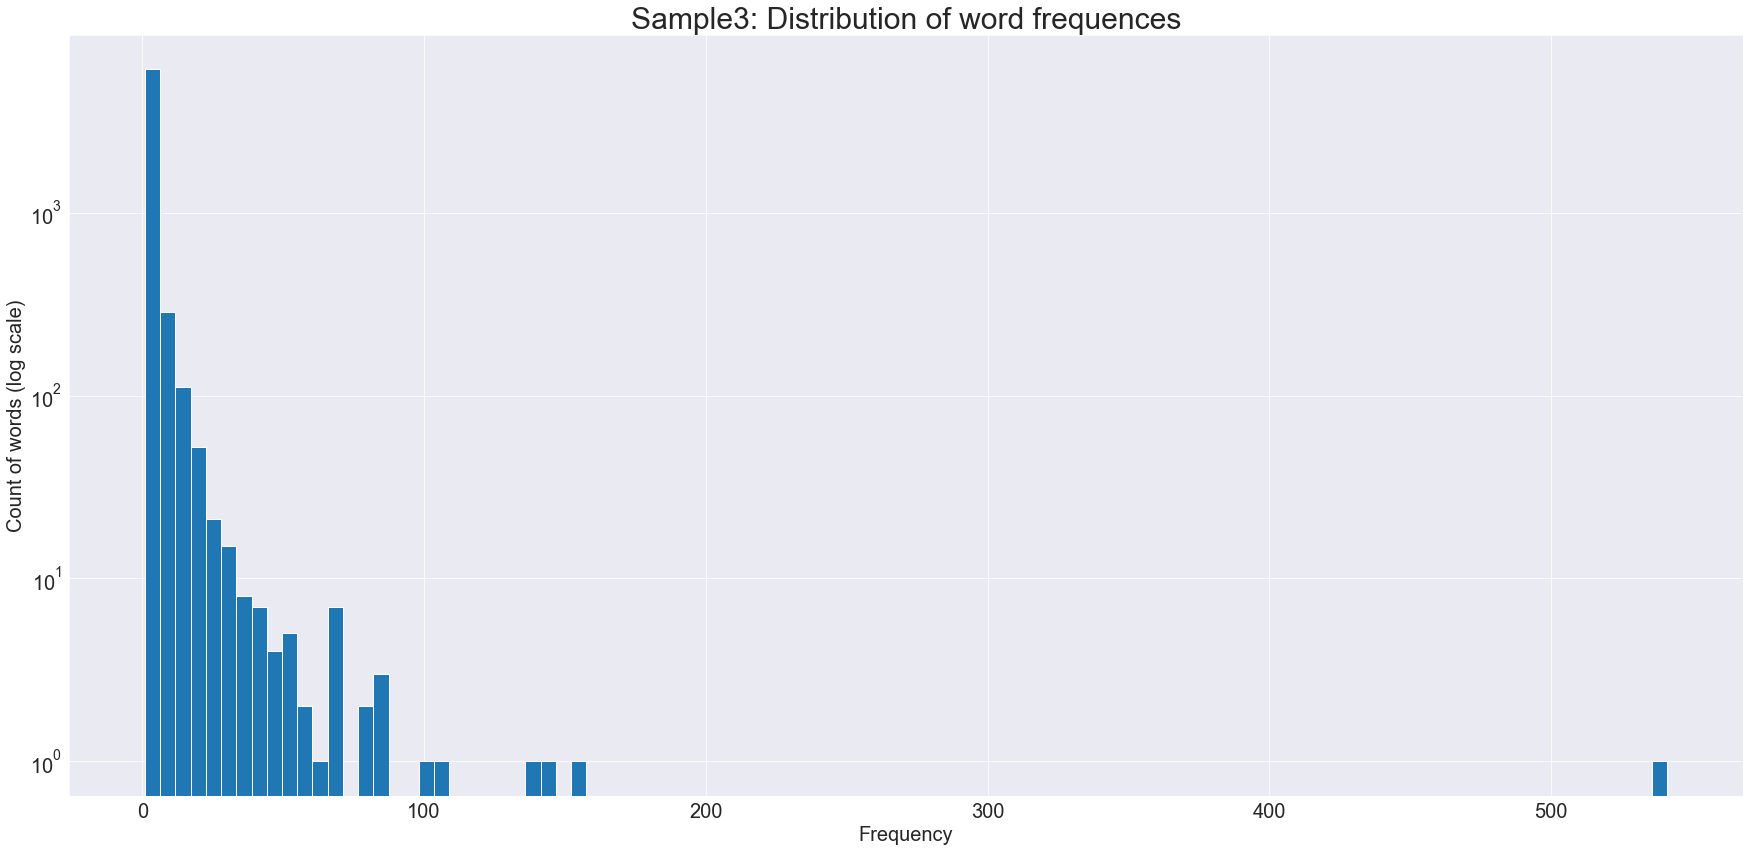

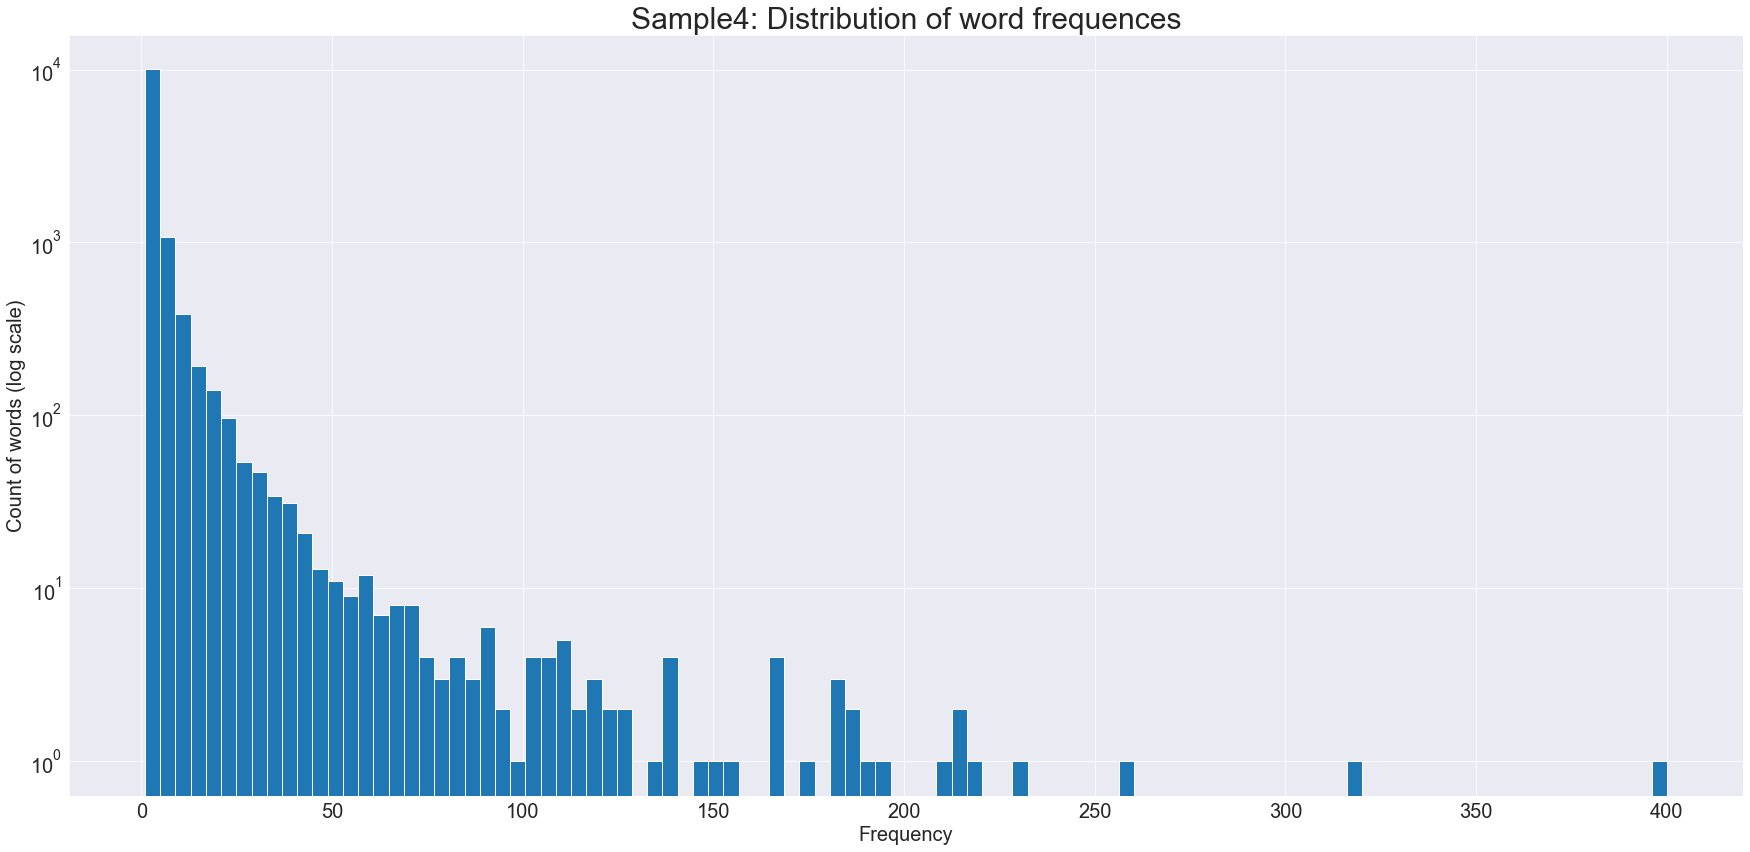

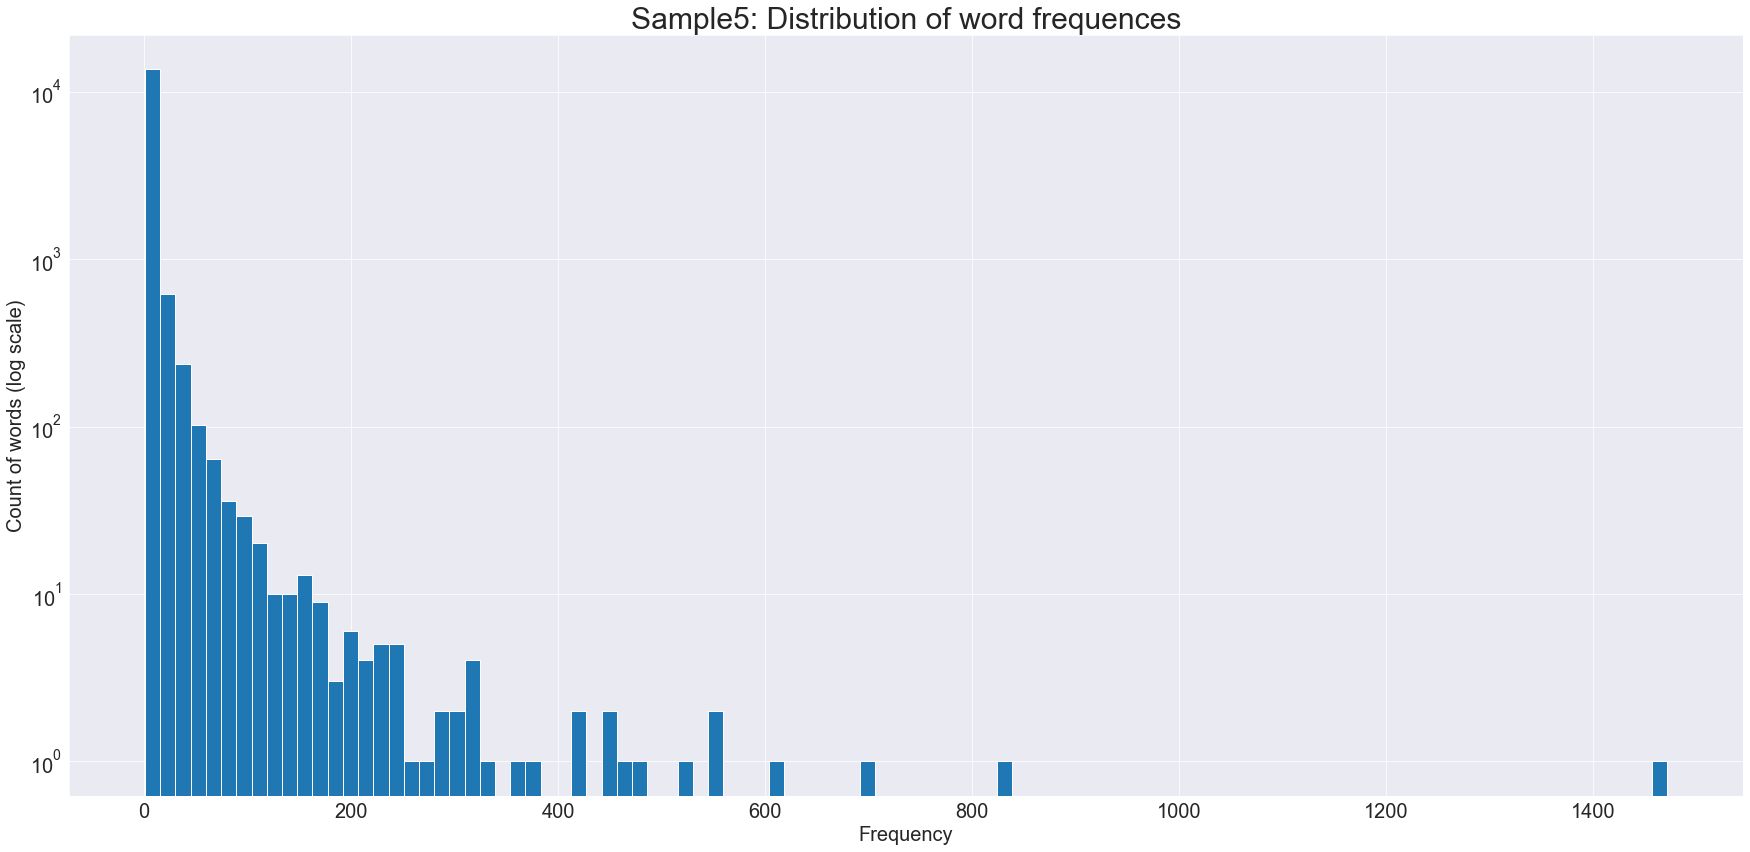

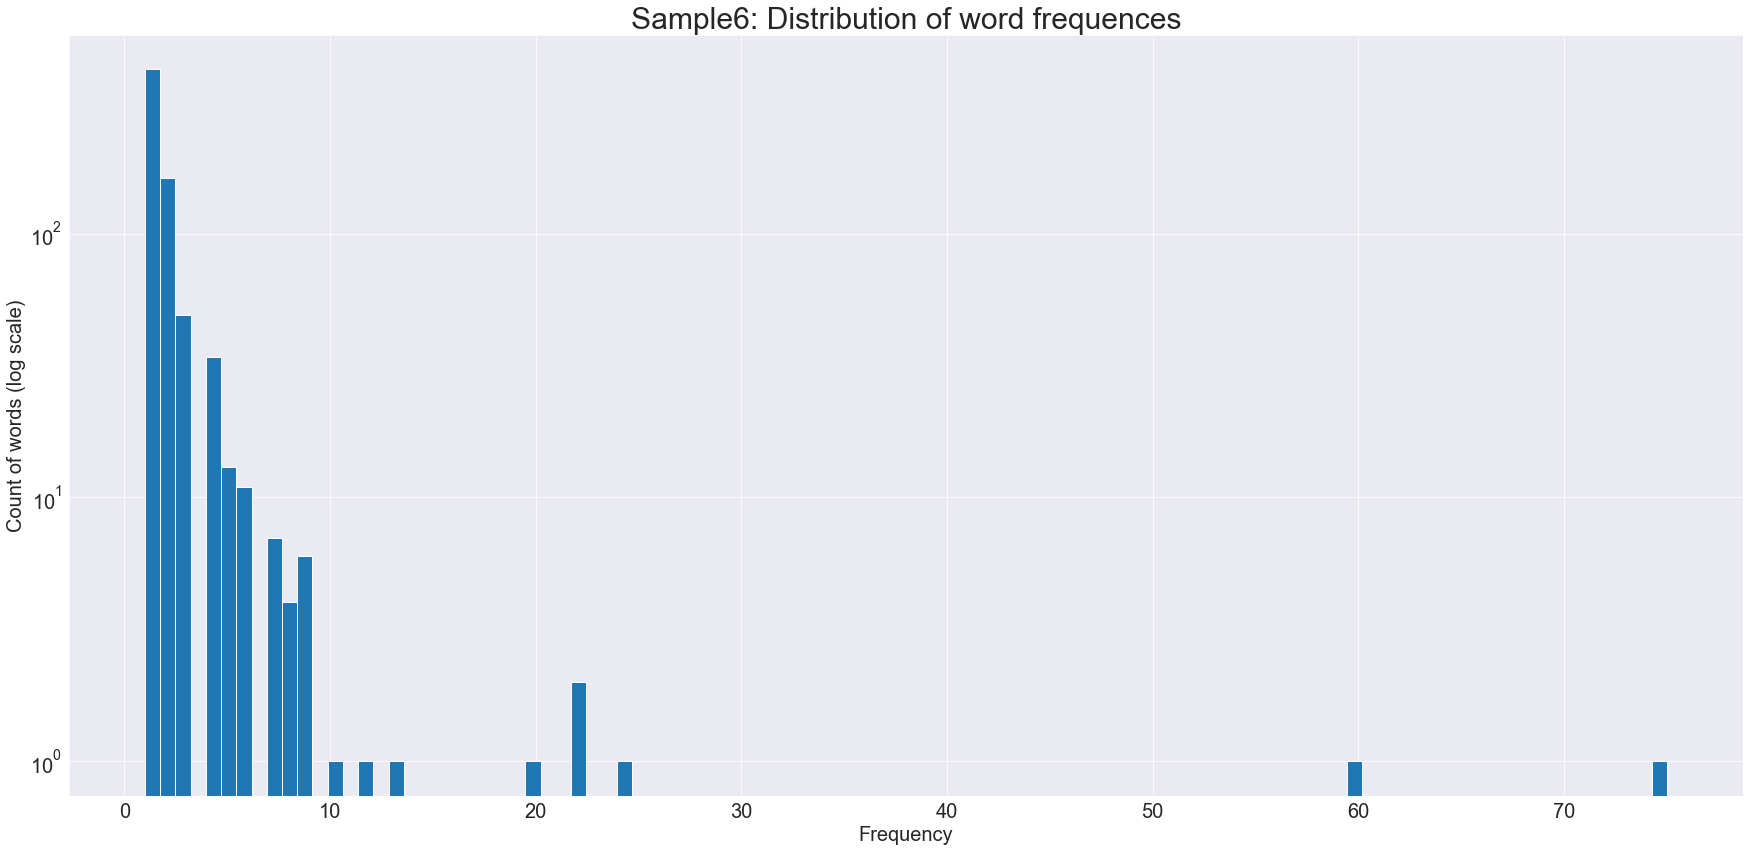

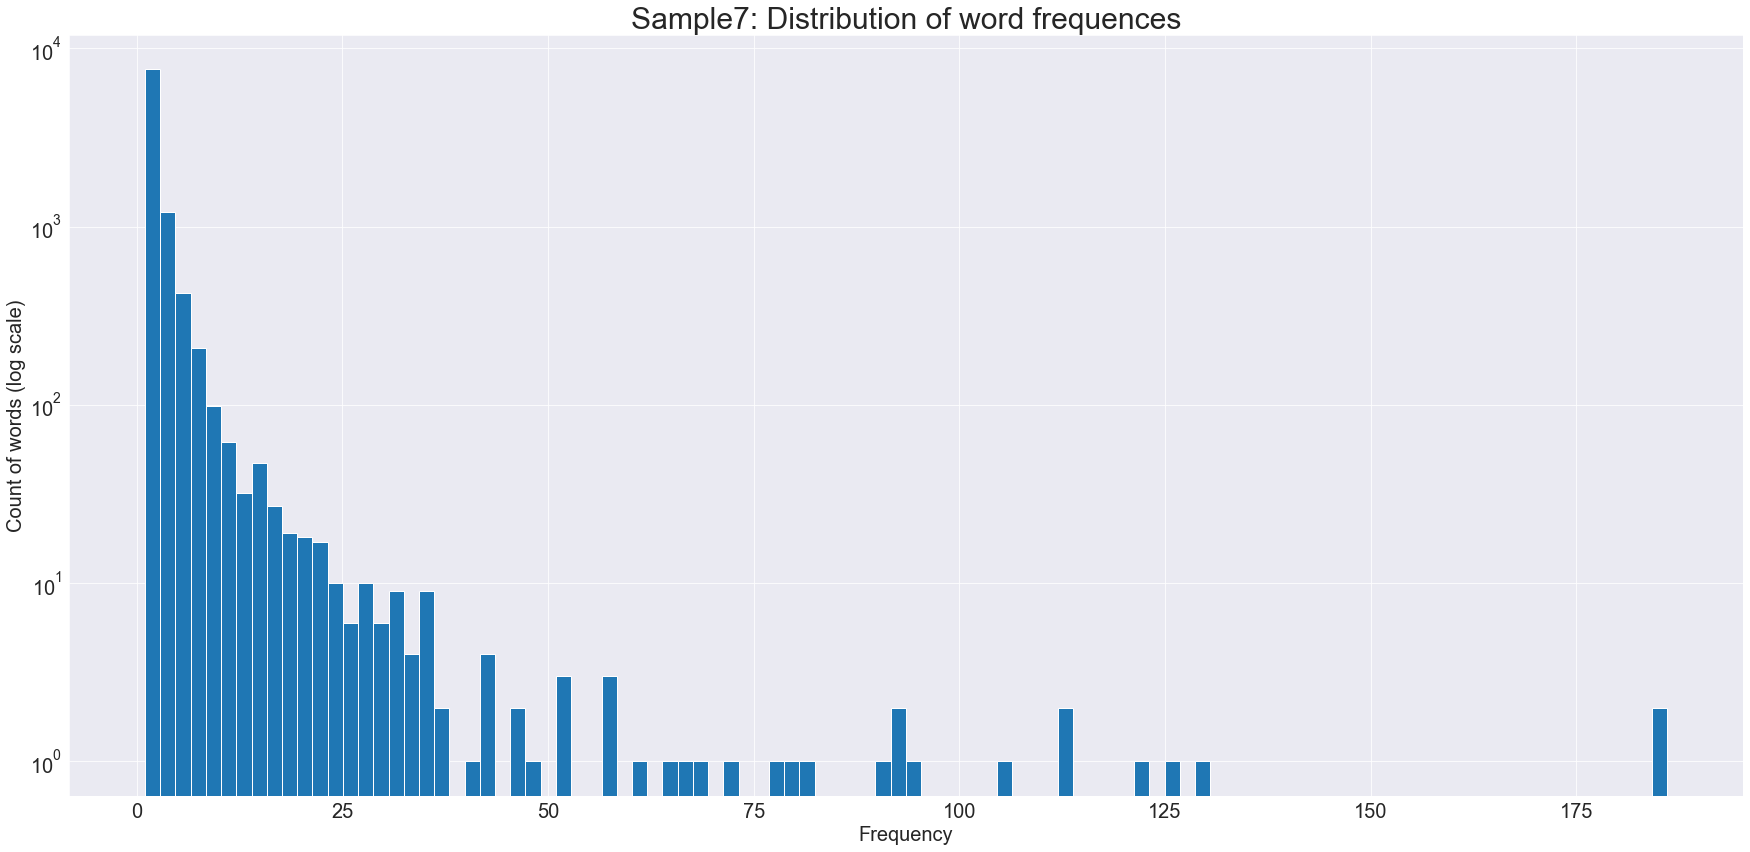

In [12]:
from collections import Counter, OrderedDict

for i, sample in enumerate(processed_data):
    
    words = [word for doc in sample for word in doc]

    count = Counter(words)
    count_srt = {k: v for k, v in sorted(count.items(), key=lambda item: -item[1])}

    plt.figure(figsize=(30,14))
    plt.hist(count_srt.values(),bins=100)
    plt.title('Sample{}: Distribution of word frequences'.format(i+1),fontsize=30)
    plt.xlabel('Frequency',fontsize=20)
    plt.ylabel('Count of words (log scale)',fontsize=20)
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()